In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from glob import glob
import os

In [4]:
rel_data_dir_full = './data/sharew8_all/'
rel_data_dir_easy = './data/sharew8_easy/'
outdir = './Project'

In [5]:
'''
Wave 8 Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 00:53:53
'''
all_files = glob(f"{rel_data_dir_full}*.dta")

'''
easySHARE Release 8.0.0
DOI: 10.6103/SHARE.easy.800
2022-02-10 01:00:22
'''
easy_files = glob(f"{rel_data_dir_easy}*.dta")

'''
Wave 8 Accelerometer Epochs Release 8.0.0
DOI: 10.6103/SHARE.w8.800
2022-02-10 01:04:04
'''
acc_files = glob(f"{rel_data_dir_full}dta/**/*.dta", recursive=True)

Loading the datasets from SHARE 

In [6]:
df_easy = pd.read_stata(easy_files[0])
df_ph = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_ph.dta'))
df_acc_hr = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_hour.dta'))
df_acc = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_accelerometer_total.dta'))
df_acc_imp = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_gv_imputations.dta'))
df_acscore = pd.read_stata(os.path.join(rel_data_dir_full, 'sharew8_rel8-0-0_br.dta'))
df_acc_hr_clean = df_acc_hr.iloc[:,0:15]

Data prep

In [7]:
df_acc_hr_clean.loc[:, 'OxCGRT_stay_at_home'] = df_acc_hr_clean['OxCGRT_stay_at_home'].replace({
    'No measures': 'No restrictions',
    "Require not leaving house with exceptions for daily exercise, grocery shopping, and 'essential' trips": 'Essential only',
    "Recommend not leaving house": 'Stay at home',
})

In [8]:
def get_common_columns(df1, df2, merge_on=['mergeid']):
    common = df1.columns.difference(df2.columns).tolist()
    common.extend(merge_on)
    return common

In [9]:
df = df_acc_hr_clean.copy()
df = pd.merge(left=df, left_on=['mergeid'], right=df_ph[get_common_columns(df_ph, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_acc[get_common_columns(df_acc, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_easy[get_common_columns(df_easy, df)], right_on=['mergeid'], how='left')
df = pd.merge(left=df, left_on=['mergeid'], right=df_acscore[get_common_columns(df_acscore, df)], right_on=['mergeid'], how='left')
df = df[df['wave'] == 8]

In [10]:
def map_selected_num(df, columns: list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].map({
            'Selected': 1,
            'Not selected': 0,
            "Don't know": -1,
            'Refusal': -2,
            1: 1,
            0: 0,
            -1: -1,
            -2: -2,
        })
    return df

def map_bmi_num(df, columns: list[str] = ['bmi']):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-3. implausible value/suspected wrong': -1,
        })
        df[c] = df[c].astype(float)
    return df

def map_freq_num(df, columns:list[str]):
    df = df.copy()
    for c in columns:
        df.loc[:, c] = df[c].replace({
            'More than once a week': 1,
            'Once a week': 2,
            'One to three times a month': 3,
            'Hardly ever, or never': 4,
            "Don't know": -1,
            'Refusal' : -1,
            '1. More than once a week': 1,
            '2. Once a week': 2,
            '3. One to three times a month': 3,
            '4. Hardly ever, or never': 4,
            "5. Don't know": -1,
            '6. Refusal' : -1,
            '-15. no information': -1,
            '-13. not asked in this wave': -1,
            "-12. don't know / refusal": -1,
            '-10. SHARELIFE interview': -1,
        })
        df[c] = df[c].astype(float)
    return df

In [11]:
#                        Hypertension, Diabetis, Osteoarthritis, pain hips, pain knee
df = map_selected_num(df, ['ph006d2', 'ph006d5', 'ph006d20', 'ph087d2', 'ph087d3'])
df = map_bmi_num(df)
df = map_freq_num(df, ['br015_', 'br016_'])   
df['br015_'].value_counts()

4.0    68400
1.0    47088
2.0    22416
3.0    15696
Name: br015_, dtype: int64

In [12]:
df['female'] = pd.to_numeric(df['female'].replace({'1. female': 1, '0. male': 0}))
df.loc[:, 'age'] = df.replace({'-15. no information': -1})
df.loc[:, 'age'] = df['age'].astype(float)

Defining Osteoarthritis 

ph006d20: Osteoarthritis/other rheumatism: ever diagnosed/currently having

ph087d2: Pain location: hips or
ph087d3: Pain location: knees

In [13]:
df['ph006d2'] = pd.to_numeric(df['ph006d2'])
df['ph006d5'] = pd.to_numeric(df['ph006d5'])

df['OA'] = np.where(((df['ph006d20'] == 1) & (df['ph087d2'] == 1)) | ((df['ph006d20'] == 1) & (df['ph087d3'] == 1)), int(1), int(0))
df['Hypertension'] = np.where(df['ph006d2'] == 1, int(1), int(0))
df['Diabetes'] = np.where(df['ph006d5'] == 1, int(1), int(0))
df['control'] = np.where((df['Hypertension'] == 0) & (df['OA'] == 0) & (df['OA'] == 0), int(1), int(0))

In [14]:
df['disease']  = df[['Hypertension', 'Diabetes', 'OA', 'control',]].apply(lambda x: x.idxmax(), axis=1)
df['disease'].value_counts()

control         68352
Hypertension    67656
Diabetes         8976
OA               8616
Name: disease, dtype: int64

Self-reported activity score

0-1: very low

2-3: moderately low

4-7: moderately high

8-9: high

In [15]:
df['activity'] = 2*(4-df['br015_']) + (4-df['br016_'])
df['activity'] 

4         9.0
9         9.0
14        9.0
19        9.0
24        9.0
         ... 
799539    4.0
799544    4.0
799549    4.0
799554    4.0
799559    4.0
Name: activity, Length: 153600, dtype: float64

In [16]:
df.drop(df[df.measurementday > 7].index, inplace=True)

In [17]:
vars = ['mergeid', 'female', 'age', 'bmi','activity', 'GGIR_mean_ENMO_hour','GGIR_N_valid_hours','hour','measurementday','weekday','month',
        'year','device_id', 'frequency', 'position', 'country','disease', 'Hypertension', 'Diabetes', 'OA']
df_stat = df[vars].copy()
df_stat.rename(columns={'GGIR_mean_ENMO_hour': 'ENMO_hour'}, inplace=True)

In [18]:
def calc_ENMO_stats(df, enmo_col='ENMO_hour'):
    df = df.copy()
    mean = df.groupby('mergeid')[enmo_col].mean()
    median = df.groupby('mergeid')[enmo_col].median()
    var = df.groupby('mergeid')[enmo_col].var()
    mean.name = 'mean_ENMO'
    median.name = 'median_ENMO'
    var.name = 'var_ENMO'
    df = pd.merge(left=df, left_on='mergeid', right=mean, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=median, right_on='mergeid', how='left')
    df = pd.merge(left=df, left_on='mergeid', right=var, right_on='mergeid', how='left')
    return df

In [19]:
df_stat= calc_ENMO_stats(df_stat)   
df_stat = df_stat.drop_duplicates(subset='mergeid', keep='first')
cols = ['ENMO_hour','GGIR_N_valid_hours','measurementday', 'hour', 'weekday']
df_stat.drop(cols, inplace=True, axis=1)
df_stat.head(5)

,mergeid,female,age,bmi,activity,month,year,device_id,frequency,position,country,disease,Hypertension,Diabetes,OA,mean_ENMO,median_ENMO,var_ENMO
0,Bf-031257-01,0,67.000000,21.155294,9.0,February,2020,68652.0,50,Left,Belgium,control,0,0,0,12.164127,9.664236,119.962879
168,Bf-043946-02,1,57.299999,38.446751,2.0,February,2020,30920.0,50,Left,Belgium,Hypertension,1,0,0,13.780020,8.492361,209.996045
336,Bf-073169-01,0,72.500000,25.209202,9.0,March,2020,68652.0,50,Right,Belgium,Hypertension,1,0,0,16.090929,11.452292,537.459251
504,Bf-227520-04,0,56.099998,24.593210,2.0,March,2020,17212.0,50,Right,Belgium,Hypertension,1,0,0,11.543128,11.326111,74.794850
552,Bf-286437-02,1,68.099998,30.778702,1.0,February,2020,54007.0,50,Right,Belgium,Hypertension,1,0,0,38.811152,48.127569,367.199181


ANOVA Self-reported activity score

<AxesSubplot:title={'center':'activity'}, xlabel='disease'>

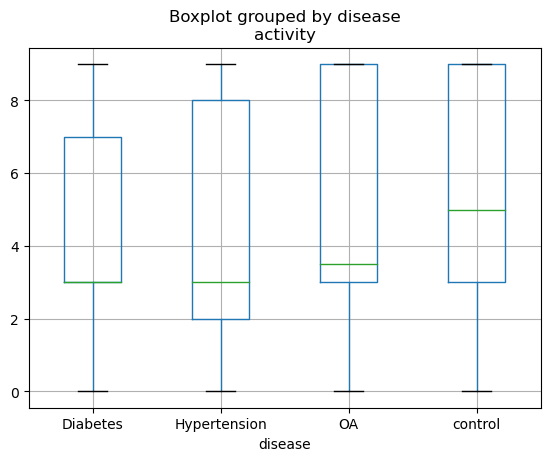

In [20]:
df_stat.boxplot(column='activity', by='disease')

ANOVA (Disease: true/false)

In [21]:
import scipy.stats as stats
H = df_stat[df_stat['Hypertension']==1]['var_ENMO']
_H = df_stat[df_stat['Hypertension']==0]['var_ENMO']
D = df_stat[df_stat['Diabetes']==1]['var_ENMO']
_D = df_stat[df_stat['Diabetes']==0]['var_ENMO']
OA = df_stat[df_stat['OA']==1]['var_ENMO']
_OA = df_stat[df_stat['OA']==0]['var_ENMO']

In [22]:
stats.f_oneway(H, _H)

F_onewayResult(statistic=4.629038511898304, pvalue=0.03171499229619758)

In [23]:
stats.f_oneway(D, _D)

F_onewayResult(statistic=0.17350982539044624, pvalue=0.6771158378345912)

In [24]:
stats.f_oneway(OA, _OA)

F_onewayResult(statistic=2.7791564286741655, pvalue=0.0958651054046013)

In [25]:
H = df_stat[df_stat['Hypertension']==1]['activity']
_H = df_stat[df_stat['Hypertension']==0]['activity']
D = df_stat[df_stat['Diabetes']==1]['activity']
_D = df_stat[df_stat['Diabetes']==0]['activity']
OA = df_stat[df_stat['OA']==1]['activity']
_OA = df_stat[df_stat['OA']==0]['activity']

In [26]:
stats.f_oneway(H, _H)

F_onewayResult(statistic=6.321811840631495, pvalue=0.012108970978511994)

In [27]:
stats.f_oneway(D, _D)

F_onewayResult(statistic=8.376412578644514, pvalue=0.0038980108521806814)

In [28]:
stats.f_oneway(OA, _OA)

F_onewayResult(statistic=3.453588730942582, pvalue=0.06345848641785197)

Regression

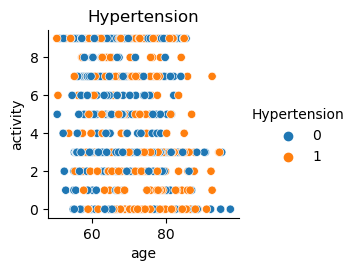

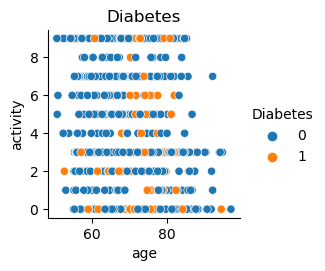

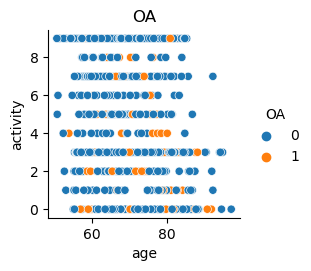

In [94]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    sns.pairplot(df_stat,x_vars=['age'],y_vars=['activity'],hue=d)
    plt.title(f'{d}')
    plt.show()

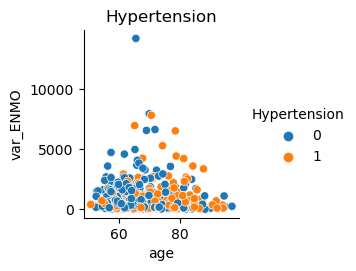

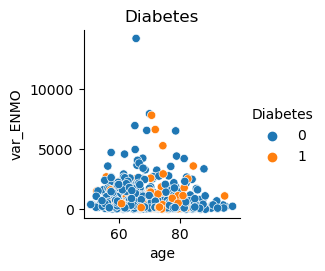

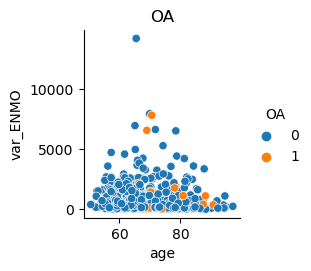

In [95]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    sns.pairplot(df_stat,x_vars=['age'],y_vars=['var_ENMO'],hue=d)
    plt.title(f'{d}')
    plt.show()

In [74]:
def qqplot(data, x, y, hue=None, palette='viridis', figsize=[6,6], *args, **kwargs):

    fig = plt.figure(figsize=figsize)
    if hue != None:
        for h,df in data.sort_values([hue]).groupby(by=hue, ):
            _, xr = stats.probplot(df[x].to_list(), fit=False)
            _, yr = stats.probplot(df[y].to_list(), fit=False)
            
            sns.scatterplot(x=xr, y=yr, label=h, edgecolor="none", palette=palette, *args, *kwargs)
    else:
        _, xr = stats.probplot(data[x].to_list(), fit=False)
        _, yr = stats.probplot(data[y].to_list(), fit=False)
        
        sns.scatterplot(x=xr, y=yr, edgecolor="none", palette=palette, *args, *kwargs)
        
    return fig

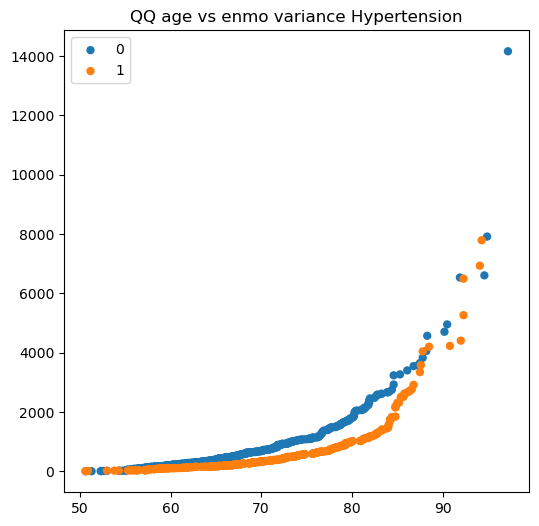

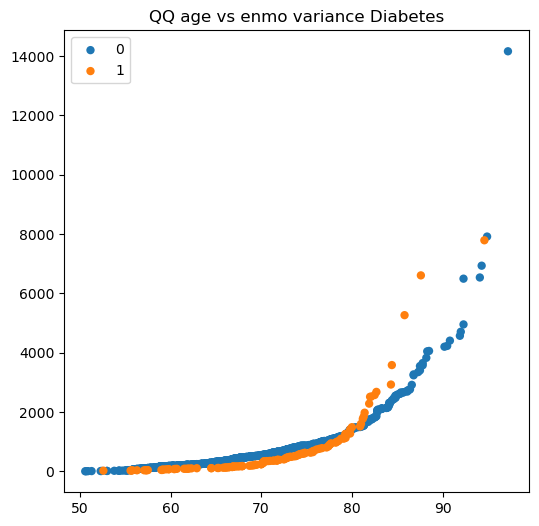

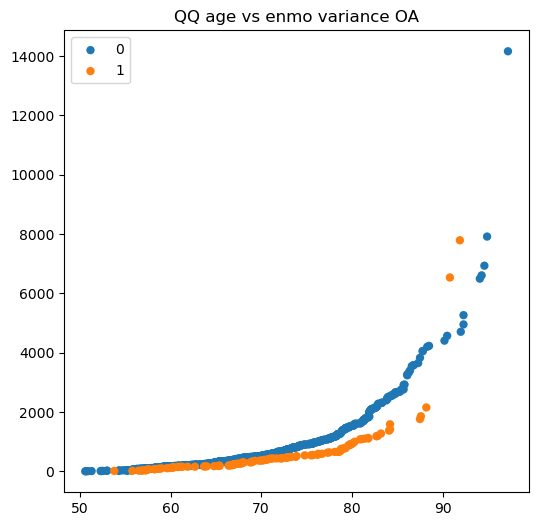

In [90]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    _df = df_stat.dropna(subset=[d, 'age', 'var_ENMO'])
    p = qqplot(data=_df, x='age', y='var_ENMO', hue=d)
    plt.title(f'QQ age vs enmo variance {d}')
    plt.show()

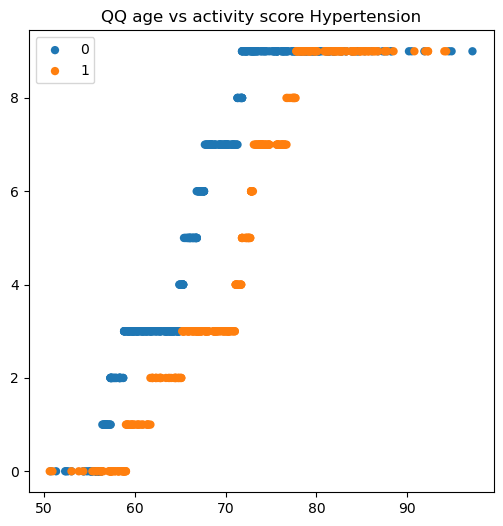

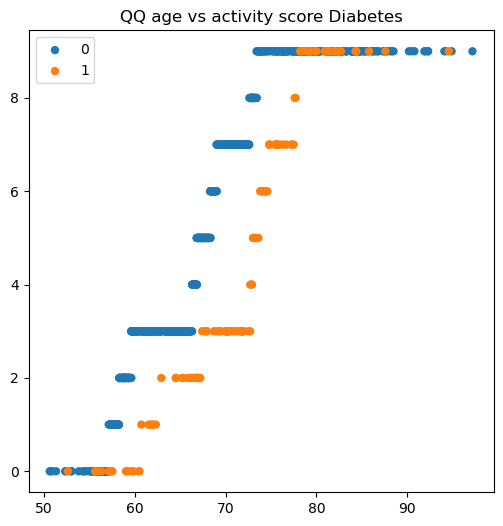

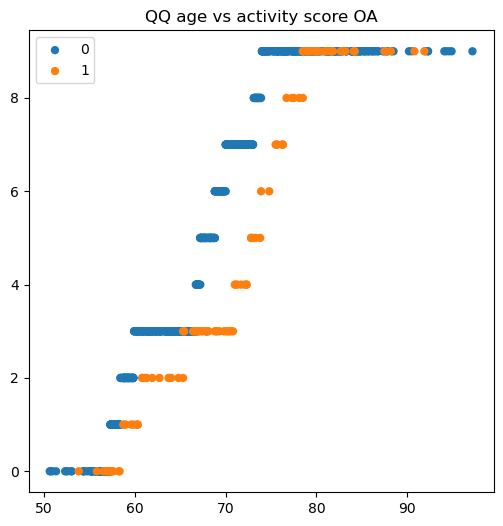

In [91]:
for d in ['Hypertension', 'Diabetes', 'OA']:
    _df = df_stat.dropna(subset=[d, 'age', 'activity'])
    p = qqplot(data=_df, x='age', y='activity', hue=d)
    plt.title(f'QQ age vs activity score {d}')
    plt.show()

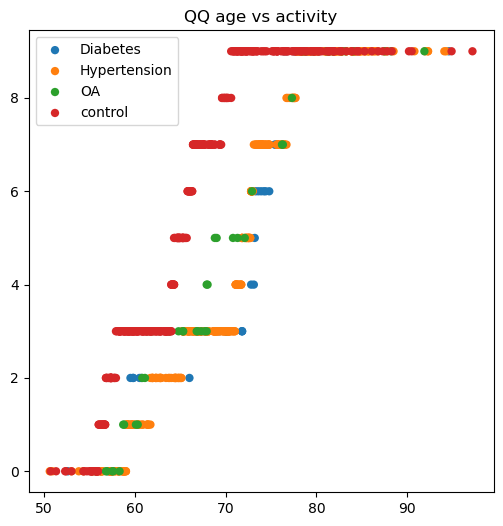

In [79]:
qqplot(data=df_stat, x='age', y='activity', hue='disease')
plt.title('QQ age vs activity')
plt.show()

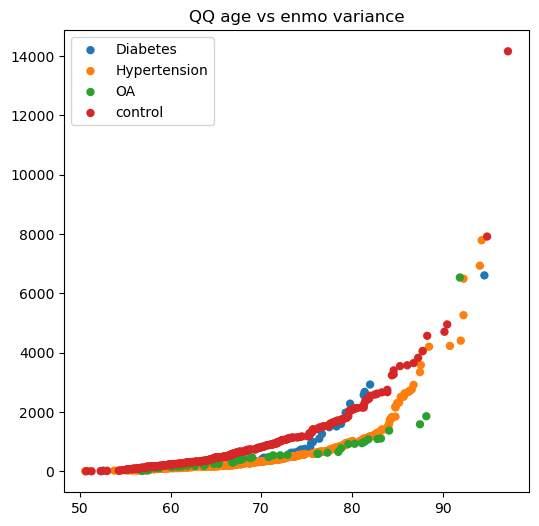

In [80]:
qqplot(data=df_stat, x='age', y='var_ENMO', hue='disease')
plt.title('QQ age vs enmo variance')
plt.show()

AttributeError: 'int' object has no attribute 'plot'

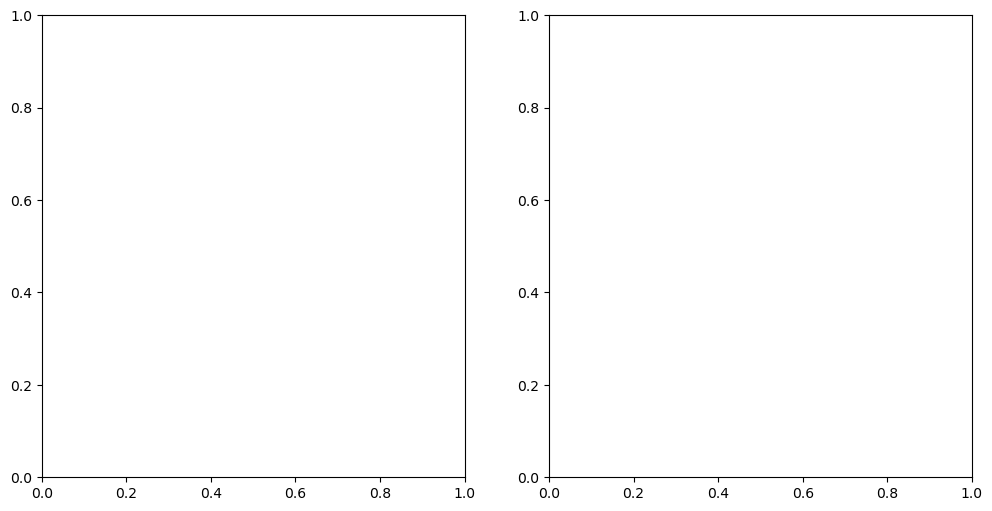

In [32]:
fig, [ax0, ax1] = plt.subplots(1, 2)
fig.set_size_inches([12,6])
sns.regplot(data=df_stat, x="Hypertension", y="activity", ax=0)
sns.residplot(data=df_stat, x="Hypertension", y="activity", ax=1)
plt.show()